# ENSO example notebook

This notebook contains an example of data access of ERA5 data with the `Reader` class and evaluation of the NINO3.4 teleconnection (regional mean) with `aqua` libraries and examples of the plotting routines.

In [2]:
import datetime
import sys
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from aqua import Reader
sys.path.insert(0, '../') # Hack to import from parent directory, to be removed
from index import regional_mean_index, regional_mean_anomalies
from plots import simple_plot, cor_plot, index_plot
from tools import load_namelist

## Teleconnection details configuration

Details such as teleconnection coordinates, folder input/output are obtained with functions collected in the `tools.py` file, that access details from a `yaml` file. The function `load_namelist` loads data specific to the choosen teleconnection such as coordinates.

Details about the ENSO teleconnection can be accessed by specificing the teleconnection name as a string. The field required to evaluate the teleconnection is also specified in the `namelist`. (WIP to be automatically fixed by the reader)

## ENSO with ERA5 data

In [3]:
diagname  = 'teleconnections'
telecname = 'ENSO'
exp       = 'ERA5'

namelist = load_namelist(diagname,configdir='../')

field = namelist[telecname]['field']

In [4]:
namelist

{'NAO': {'field': 'msl',
  'lat1': 37.7,
  'lon1': -25.7,
  'lat2': 64.1,
  'lon2': -22},
 'NAO_lisbon': {'field': 'msl',
  'lat1': 38.7,
  'lon1': -9.1,
  'lat2': 64.1,
  'lon2': -22},
 'ENSO': {'field': 'skt', 'latN': 5, 'lonW': -170, 'latS': -5, 'lonE': -120},
 'MJO': {'field': 'ttr', 'latN': 10, 'latS': -10, 'lonW': 30, 'lonE': 200}}

## Retrieve data with the intake AQUA functionality

Data required for the teleconnection are retrieved with the `Reader` class from the `AQUA` framework (see framework notebooks for a comprehensive list of examples).

In [5]:
configdir = '../../../config/'

reader = Reader(model='ERA5',exp='era5',source='monthly_inst',configdir=configdir,regrid='r100',var=field)

In [6]:
data = reader.retrieve()
data

<xarray.Dataset>
Dimensions:     (time: 516, values: 542080)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    step        timedelta64[ns] ...
    surface     float64 ...
    lat         (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    lon         (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    valid_time  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: values
Data variables:
    skt         (time, values) float32 dask.array<chunksize=(1, 542080), meta=np.ndarray>
Attributes:
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    intake_esm_varname:      ['skt']
    history:                 2023-03-22T16:36 GRIB to CDM+CF via cfgrib-0.9.1...
    intake_esm_dataset_key:  128.0.avgua.surface.monthly

## Data preparation

The `Reader` returns a `Dataset`. It is needed to select the data for the desired variable and regrid before calling the library function.

In [7]:
infile = data[field]
infile = reader.regrid(infile)
infile

<xarray.DataArray 'skt' (time: 516, lat: 180, lon: 360)>
dask.array<reshape, shape=(516, 180, 360), dtype=float64, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    step        timedelta64[ns] ...
    surface     float64 ...
    valid_time  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Attributes: (12/22)
    GRIB_paramId:                    235
    GRIB_dataType:                   an
    GRIB_numberOfPoints:             542080
    GRIB_typeOfLevel:                surface
    GRIB_stepUnits:                  1
    GRIB_stepType:                   avgua
    ...                              ...
    GRIB_totalNumber:                0
    GRIB_units:                      K
    long_name:                       Skin temperature
    units:                           K
    standard_name:                   unknown
    regridded:                       1

## Teleconnection evaluation

The NINO3.4 can be evaluated by using the library function `regional_mean_index` from the `index.py` file.

The teleconnection can be evaluated with a custom rolling window to average data (standard is 3 months, here written explicitely for sake of clarity).

The function returns a `DataArray` with the timeserie of values.


In [8]:
enso = regional_mean_index(infile,namelist,telecname,months_window=1)

The timeserie can be plot with the `simple_plot` function from the `plots.py` file, already with some extra optional arguments in order to make a nice plot.

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'ENSO Index, Nino 3.4'}, xlabel='time', ylabel='Skin temperature [K]'>)

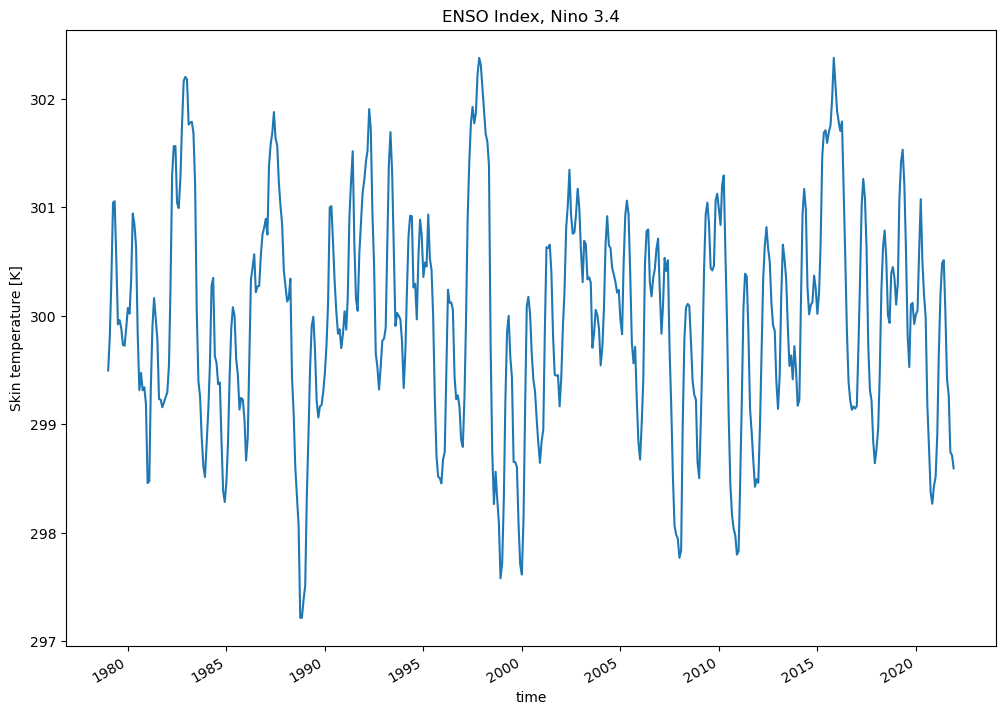

In [11]:
simple_plot(enso,title='ENSO Index, Nino 3.4',ylabel='Skin temperature [K]',
            save=True,filename='enso_index.png',outputdir='../img/')

## Correlation plot

To visualize the teleconnection on a 2D plot functions in the `plots.py` are introduced.
There is an option `plot=True` that creates a plot of the correlation. Additionally an xarray containing the result of the regression is returned, if needed for further analysis or storage.
A custom projection can be specified.

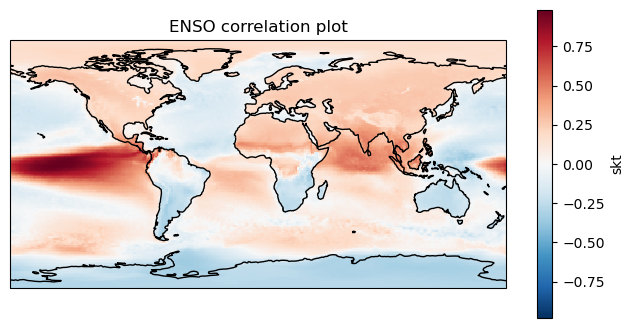

In [9]:
enso_cor = cor_plot(enso,infile,title='ENSO correlation plot',save=True,
                    filename='enso_cor.png',outputdir='../img/')

## ENSO Nino3.4 anomalies

Another library function is introduced, able to evaluate anomalies of a regional mean index. The function `regional_mean_anomalies` returns a `DataArray` with the anomalies.

Also for this function, an optional parameter `months_window` can be specified to average the data before computing the anomalies.

In [13]:
enso_an = regional_mean_anomalies(infile,namelist,telecname,months_window=1)

/work/bb1153/b382289/mambaforge/envs/teleconnections/lib/python3.10/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


The timeserie can be plot with the `index_plot` function from the `plots.py` file, already with some customization in order to make a nice plot.

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'ENSO Anomalies, Nino 3.4'}, xlabel='time', ylabel='Skin temperature anomalies [K]'>)

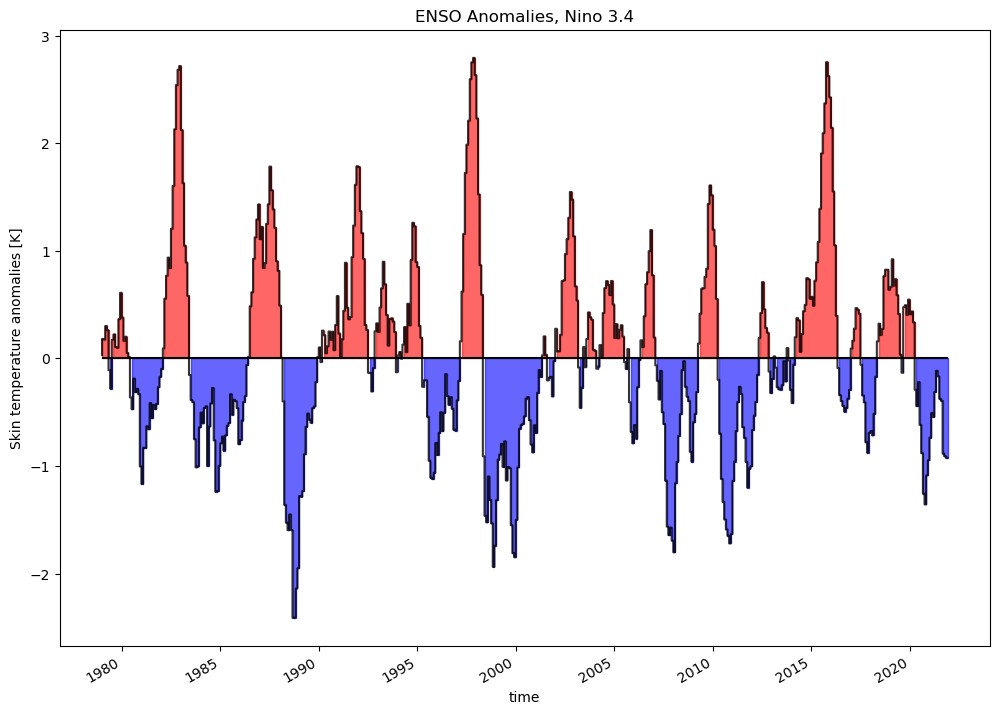

In [14]:
index_plot(enso_an,title='ENSO Anomalies, Nino 3.4',ylabel='Skin temperature anomalies [K]',
           save=True,filename='enso_an.png',outputdir='../img/')

## NCAR comparison

With the NINO3.4 anomalies and monthly data computed, we can compare with observational data from NCAR, to check if the index is computed correctly.

In [15]:
ncar_path = '../data/nina34.anom.txt'
enso_ncar = np.genfromtxt(ncar_path,skip_header=3,skip_footer=4)

In [16]:
# If some missing value is remaining
for i in enso_ncar:
    for j in i:
        if j == -99.99:
            j = np.nan

In [17]:
year = enso_ncar[:,0]
month_data = enso_ncar[:, 1:]
time = xr.cftime_range(start=str(int(year[0])),periods=12*len(year),freq='MS',calendar='standard')
month_data = month_data.reshape(-1)
enso_ncar = xr.DataArray(month_data, coords=[time], dims=['time'], name='monthly_data')

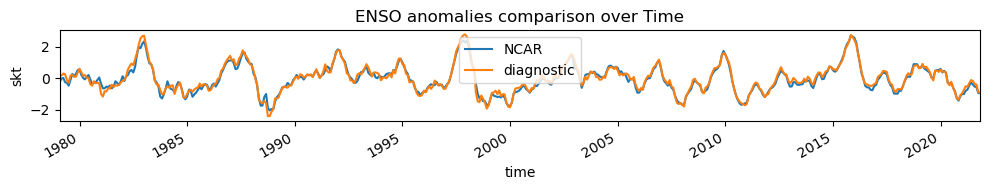

In [18]:
time_vals = np.array(time.values)

# Convert to datetime objects
datetimes = [np.datetime64(t).astype(datetime.datetime) for t in time_vals]

# Plot with matplotlib
fig = plt.figure(figsize=(10,2))
plt.plot(datetimes, enso_ncar.values,label='NCAR')

plt.xlim(datetime.datetime(1979, 1, 31, 0, 0),datetime.datetime(2021, 10, 31, 0, 0))
#plt.ylim(-5,+5)

enso_an.plot(label='diagnostic')
plt.legend()
plt.title('ENSO anomalies comparison over Time')
fig.tight_layout()
plt.savefig('../img/enso_an_ncar.png')
plt.show()

In [19]:
ncar_path = '../data/nina34.txt'
enso_ncar = np.genfromtxt(ncar_path,skip_header=3,skip_footer=4)

In [20]:
year = enso_ncar[:,0]
month_data = enso_ncar[:, 1:]
time = xr.cftime_range(start=str(int(year[0])),periods=12*len(year),freq='MS',calendar='standard')
month_data = month_data.reshape(-1)
enso_ncar = xr.DataArray(month_data, coords=[time], dims=['time'], name='monthly_data')

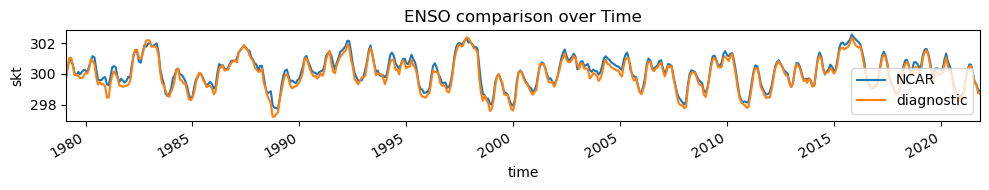

In [21]:
time_vals = np.array(time.values)

# Convert to datetime objects
datetimes = [np.datetime64(t).astype(datetime.datetime) for t in time_vals]

# Plot with matplotlib
fig = plt.figure(figsize=(10,2))
plt.plot(datetimes, enso_ncar.values+273.15,label='NCAR')

plt.xlim(datetime.datetime(1979, 1, 31, 0, 0),datetime.datetime(2021, 10, 31, 0, 0))

enso.plot(label='diagnostic')
plt.legend()
plt.title('ENSO comparison over Time')
fig.tight_layout()
plt.savefig('../img/enso_ncar.png')
plt.show()